데이터 병합

In [ ]:
import pandas as pd
import json
from pathlib import Path

# ---------- 경로 ----------
P_TRIM_NOBEEP = "/home/gaeun0112/sooho_work/data/experiment/new_treansform_data/trim_nobeep_test.json"
P_TRIM        = "/home/gaeun0112/sooho_work/data/experiment/new_treansform_data/trim_test.json"
P_RAW_CSV     = "/home/gaeun0112/sooho_work/preprocessing/preprocessed_merged_output_V3.csv"
P_OUT         = "/home/gaeun0112/sooho_work/EDA/merged_wav_eda.csv"

def json_to_df(json_path: str, colname: str) -> pd.DataFrame:
    """
    JSON의 id (mp4_날짜_고유번호_처리유형)를
    최종 키 (mp4_고유번호_날짜)로 변환하여 [id, <colname>] DF 반환
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    rows = []
    for item in data:
        sid = item.get("id", "")
        if not isinstance(sid, str) or not sid.startswith("mp4_"):
            continue
        parts = sid.split("_")
        # 기대 형태: mp4, 날짜, 고유번호, 처리유형(들)
        if len(parts) < 3:
            continue
        date = parts[1]
        uniq = parts[2]
        base_id = f"mp4_{uniq}_{date}"
        rows.append({"id": base_id, colname: item.get("text", "")})

    if not rows:
        return pd.DataFrame(columns=["id", colname])

    df = pd.DataFrame(rows)
    # 혹시 동일 id가 여러 개면 텍스트를 줄바꿈으로 합침
    df = df.groupby("id", as_index=False).agg({colname: lambda s: "\n".join([x for x in s if isinstance(x, str)])})
    return df

# 1) raw (CSV) 불러오기: mp4로 시작하는 id만, [id, text] -> [id, raw]
raw = pd.read_csv(P_RAW_CSV, dtype=str)
raw = raw[raw["id"].str.startswith("mp4_", na=False)].copy()
raw = raw[["id", "text"]].rename(columns={"text": "raw"})
raw = raw.groupby("id", as_index=False)["raw"].agg(lambda s: "\n".join([x for x in s if isinstance(x, str)]))

# 2) trim / trim_nobeep (JSON) 불러오기
df_trim        = json_to_df(P_TRIM,        "trim")
df_trim_nobeep = json_to_df(P_TRIM_NOBEEP, "trim_nobeep")

# 3) 병합 (외부조인으로 세 소스의 mp4 항목 전체 커버)
merged = raw.merge(df_trim, on="id", how="outer").merge(df_trim_nobeep, on="id", how="outer")

# 보기 좋게 정렬
merged = merged.sort_values("id").reset_index(drop=True)

# 4) 저장 (엑셀 호환을 위해 utf-8-sig)
Path(P_OUT).parent.mkdir(parents=True, exist_ok=True)
merged.to_csv(P_OUT, index=False, encoding="utf-8-sig")

print(f"Saved: {P_OUT}  shape={merged.shape}")


Saved: /home/gaeun0112/sooho_work/EDA/merged_wav_eda.csv  shape=(94, 4)


In [30]:
df = pd.read_csv('/home/gaeun0112/sooho_work/EDA/merged_wav_eda.csv', encoding = 'utf-8-sig')

전처리 칼럼 생성

In [ ]:
df = df.reset_index(drop=True)
df

,id,raw,trim,trim_nobeep
0,mp4_01_20231006,사례1: 네 그 녹취록에는 이제 자금이나 제3자 목소리가 개입되면 안 되고 지금 수...,녹취 중에는 자금이나 제3자 목소리가 개입되면 안되고 지금 수사 중인 사건이어서 수...,녹취 중에는 자금이나 제3자 목소리가 개입되면 안되고 지금 수사 중인 사건이어서 수...
1,mp4_02_20231006,사례1: 예 조사하는 모든 통화 내용을 녹취를 하게 됩니다.\n증거 자료로 채택이 ...,조사하는 모든 통화내용을 녹취로 하게 됩니다. 증거자료를 채택해서 피해자 입증에 유...,조사하는 모든 통화내용을 녹취로 하게 됩니다. 증거자료를 채택해서 피해자 입증에 유...
2,mp4_03_20231006,사례1: 일단 저희가 현재 시간부로 본인 앞으로 금융권 전수조사를 할 건데 이걸 하...,일단 저희가 해낸 시간부로 본인 앞으로 금융권 준수소사를 할 건데 이걸 하는 이유는...,일단 저희가 해낸 시간부로 본인 앞으로 금융권 준수소사를 할 건데 이걸 하는 이유는...
3,mp4_04_20231006,사례1: 여보세요.\n\n예 여보세요. 예. 수고 많으십니다. 혹시 혹시 본인 맞으...,여보세요? 네 여보세요? 네 네 수고 많으십니다 혹시 OOO씨 본인 맞으신가요? 어...,여보세요? 네 여보세요? 네 네 수고 많으십니다 혹시 OOO씨 본인 맞으신가요? 어...
4,mp4_05_20231006,사례1: 여보세요. 여보세요. 네 담당자고요. 네 지금 통화 가능하신가요?\n네네....,여보세요. 담임 담당자고요. 지금 통화 가능하신가요. 지금 진행 결과 나오셨고요. ...,여보세요. 담임 담당자고요. 지금 통화 가능하신가요. 지금 진행 결과 나오셨고요. ...
...,...,...,...,...
89,mp4_90_20151209,사례1: 아니요 제가 동결 처리 시켰다고 말씀드렸잖아요. 이 부분은 은행에서도 확인...,아니요. 제가 동결 처리시켰다고 말씀드렸잖아요. 이 부분은 은행에서도 확인이 불가능...,아니요. 제가 동결 처리시켰다고 말씀드렸잖아요. 이 부분은 은행에서도 확인이 불가능...
90,mp4_91_20151209,사례1:\n네 그러시면 이 동결 처리를 위해서 본인에게 다시 질문 조금 드리겠습니다...,그러시면 이 동결처리를 위해서 본인에게 다시 질문 조금 드리겠습니다. 본인께서 실질...,그러시면 이 동결처리를 위해서 본인에게 다시 질문 조금 드리겠습니다. 본인께서 실질...
91,mp4_92_20150828,사례1: 예. 수고하십니다. 네 여기 서울지검 첨단범죄수사팀의 김민재 수사관이라고 ...,"네, 수고하십니다. 여기 서울지검 첨단 범죄수사팀의 김민재 수사관이라고 합니다. 네...","네, 수고하십니다. 여기 서울지검 첨단 범죄수사팀의 김민재 수사관이라고 합니다. 네..."
92,mp4_93_20150828,사례1: 아...예...뭐라고요??? 아 저희 스포OOO사무실이구요. 예. 네네~ ...,네. 뭐라고요? 저희 스포츠 사무실이고요. 네. 저희 쪽에서 통장 한 개당 300만...,네. 뭐라고요? 저희 스포츠 사무실이고요. 저희 쪽에서 지금 통장 한 개당 300만...


In [1]:
# -*- coding: utf-8 -*-
"""
WER/CER 파이프라인 (정규화 + 빠른/정밀 계산 + Alignment/혼동표)
고정 API:
- normalize_ko(text, ...)
- add_comprehensive_metrics(df, ref_col, hyp_cols, ..., fast_mode=True/False, include_alignment=...)
- confusion_from_alignment(alignment_data, tag, ...)
- run_wer_pipeline(input_csv, output_csv, ...)
"""

import re
import unicodedata
from collections import Counter
from typing import Tuple, Dict, List, Iterable, Optional
import json
import pandas as pd

# =========================
# 1) 정규화(노말라이즈)
# =========================

P_TAG   = re.compile(r"[\(\[].*?[\)\]]")                          # 괄호/대괄호 안 내용
P_PUNC  = re.compile(r"[^\w\s\u3130-\u318F\uAC00-\uD7A3]")        # 한글/영문/숫자/밑줄/공백 외 제거
P_SPACE = re.compile(r"\s+")
P_SCENARIO = re.compile(r"(?<!\w)사례\s*0*\d*\s*[-.:：)\]]?\s*(?=\S)")
P_SLASHES  = re.compile(r"\\[nrtv]")                              # 리터럴 \n \r \t \v

def normalize_ko(
    text: str,
    numblind: bool = False,
    drop_fillers: bool = False,
    preserve_case: bool = False,
    custom_fillers: Optional[set] = None):
    
    """한국어 텍스트 정규화(사례 라벨/개행/괄호태그/문장부호/공백 정리)."""
    if not isinstance(text, str):
        return ""
    t = unicodedata.normalize("NFC", text)

    # 1) 리터럴/실제 개행·탭 제거
    t = P_SLASHES.sub(" ", t)
    t = t.replace("\n", " ").replace("\r", " ").replace("\t", " ")

    # 2) 사례 라벨 제거(문장부호 제거 전에)
    t = P_SCENARIO.sub(" ", t)

    # 3) 괄호 태그/문장부호 정리
    t = P_TAG.sub(" ", t)
    t = t.replace("…", " ")
    t = P_PUNC.sub(" ", t)

    # 4) 소문자화
    if not preserve_case:
        t = t.lower()

    # 5) 숫자 블라인드
    if numblind:
        t = re.sub(r"\d+(?:[.,]\d+)*", "NUM", t)

    # 6) 필러 제거(선택)
    if drop_fillers:
        fillers = custom_fillers if custom_fillers else {"음","어","에","아","자","그","네","예"}
        tokens = [tok for tok in t.split() if tok not in fillers]
        t = " ".join(tokens)

    # 7) 공백 정리
    t = P_SPACE.sub(" ", t).strip()
    return t


# =========================
# 2) 편집거리 + Alignment
# =========================

def _levenshtein_ops_with_alignment(ref_tokens: List[str], hyp_tokens: List[str]):
    """정밀 모드: S/D/I/N + alignment 반환."""
    n, m = len(ref_tokens), len(hyp_tokens)
    dp = [[(0,0,0,0) for _ in range(m+1)] for _ in range(n+1)]
    for i in range(1, n+1):
        dp[i][0] = (i, 0, i, 0)            # 삭제
    for j in range(1, m+1):
        dp[0][j] = (j, 0, 0, j)            # 삽입
    for i in range(1, n+1):
        for j in range(1, m+1):
            if ref_tokens[i-1] == hyp_tokens[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                c_s, s_s, d_s, i_s = dp[i-1][j-1]
                sub  = (c_s+1, s_s+1, d_s,   i_s)
                c_d, s_d, d_d, i_d = dp[i-1][j]
                dele = (c_d+1, s_d,   d_d+1, i_d)
                c_i, s_i, d_i, i_i = dp[i][j-1]
                ins  = (c_i+1, s_i,   d_i,   i_i+1)
                dp[i][j] = min(sub, dele, ins, key=lambda x: x[0])
    S, D, I = dp[n][m][1], dp[n][m][2], dp[n][m][3]

    # 역추적
    alignment = []
    i, j = n, m
    while i > 0 or j > 0:
        if i>0 and j>0 and ref_tokens[i-1]==hyp_tokens[j-1]:
            alignment.append((ref_tokens[i-1], hyp_tokens[j-1], "MATCH")); i-=1; j-=1
        elif i>0 and j>0 and dp[i][j] == (dp[i-1][j-1][0]+1, dp[i-1][j-1][1]+1, dp[i-1][j-1][2], dp[i-1][j-1][3]):
            alignment.append((ref_tokens[i-1], hyp_tokens[j-1], "SUB")); i-=1; j-=1
        elif i>0 and dp[i][j] == (dp[i-1][j][0]+1, dp[i-1][j][1], dp[i-1][j][2]+1, dp[i-1][j][3]):
            alignment.append((ref_tokens[i-1], "", "DEL")); i-=1
        else:
            alignment.append(("", hyp_tokens[j-1], "INS")); j-=1
    alignment.reverse()
    return S, D, I, n, alignment

# 빠른 모드: 거리만 (메모리 O(min(n,m)))
def _levenshtein_distance_fast(a: List[str], b: List[str]) -> int:
    if len(a) < len(b):
        a, b = b, a
    prev = list(range(len(b)+1))
    for i, ca in enumerate(a, 1):
        curr = [i]
        for j, cb in enumerate(b, 1):
            cost = 0 if ca == cb else 1
            curr.append(min(prev[j]+1, curr[j-1]+1, prev[j-1]+cost))
        prev = curr
    return prev[-1]

def wer_with_details(ref: str, hyp: str) -> Tuple[float, int, int, int, int, List]:
    rt, ht = ref.split(), hyp.split()
    S, D, I, N, align = _levenshtein_ops_with_alignment(rt, ht)
    return (S + D + I) / max(N, 1), S, D, I, N, align

def cer_flexible(ref: str, hyp: str, include_space: bool = False) -> Tuple[float, int, int, int, int]:
    rc = list(ref) if include_space else list(ref.replace(" ", ""))
    hc = list(hyp) if include_space else list(hyp.replace(" ", ""))
    S, D, I, N, _ = _levenshtein_ops_with_alignment(rc, hc)
    return (S + D + I) / max(N, 1), S, D, I, N

def wer(ref: str, hyp: str):
    rt, ht = ref.split(), hyp.split()
    S, D, I, N, _ = _levenshtein_ops_with_alignment(rt, ht)
    return (S + D + I) / max(N, 1), S, D, I, N

def cer(ref: str, hyp: str):
    return cer_flexible(ref, hyp, include_space=False)

# 빠른 모드용
def wer_fast(ref: str, hyp: str):
    rt, ht = ref.split(), hyp.split()
    dist = _levenshtein_distance_fast(rt, ht)
    N = max(len(rt), 1)
    return dist / N, dist, N

def cer_fast(ref: str, hyp: str, include_space=False):
    rc = list(ref) if include_space else list(ref.replace(" ", ""))
    hc = list(hyp) if include_space else list(hyp.replace(" ", ""))
    dist = _levenshtein_distance_fast(rc, hc)
    N = max(len(rc), 1)
    return dist / N, dist, N


# =========================
# 3) 메트릭 산출 (고정 API)
# =========================

def add_comprehensive_metrics(
    df: pd.DataFrame,
    ref_col: str = "raw",
    hyp_cols: Iterable[str] = ("trim", "trim_nobeep"),
    normalization_options: Optional[Dict] = None,
    include_alignment: bool = False,
    id_col: Optional[str] = "id",
    tag_map: Optional[Dict[str, str]] = None,
    fast_mode: bool = True,   # ✅ 기본 빠른모드
):
    """
    df에 샘플별 WER/CER를 붙이고, 집계/정렬정보를 반환.
    - fast_mode=True & include_alignment=False: 가장 빠름(거리만 계산)
    - include_alignment=True: 정렬/혼동표용 alignment 수집(느림)
    """
    if normalization_options is None:
        normalization_options = {"numblind": False, "drop_fillers": False, "preserve_case": False}
    if tag_map is None:
        tag_map = {}

    out = df.copy()

    # 정규화
    out["norm_ref"] = out[ref_col].apply(lambda x: normalize_ko(x, **normalization_options))
    norm_hyps: Dict[str, str] = {}
    for h in hyp_cols:
        tag = tag_map.get(h, h)
        col = f"norm_{tag}"
        out[col] = out[h].apply(lambda x: normalize_ko(x, **normalization_options))
        norm_hyps[tag] = col

    # 계산(벡터화 느낌으로 임시 DF 만들어 join)
    alignment_data: Optional[Dict[str, List[Tuple[str, str, str]]]] = {} if include_alignment else None
    rows = []
    for tag, hyp_col in norm_hyps.items():
        for idx, row in out.iterrows():
            ref_text, hyp_text = row["norm_ref"], row[hyp_col]
            if fast_mode and not include_alignment:
                w, dist_w, Nw = wer_fast(ref_text, hyp_text)
                c, dist_c, Nc = cer_fast(ref_text, hyp_text, include_space=False)
                c2, _, _        = cer_fast(ref_text, hyp_text, include_space=True)
                rows.append({
                    "idx__": idx,
                    f"wer_{tag}": w, f"Nw_{tag}": Nw,
                    f"cer_{tag}": c, f"Nc_{tag}": Nc,
                    f"cer_space_{tag}": c2
                })
            else:
                if include_alignment:
                    w, s, d, i, n, align = wer_with_details(ref_text, hyp_text)
                    rid = str(row[id_col]) if (id_col and id_col in out.columns) else str(idx)
                    alignment_data[f"{rid}::{tag}"] = align
                else:
                    w, s, d, i, n = wer(ref_text, hyp_text)
                c, cs, cd, ci, cn = cer_flexible(ref_text, hyp_text, include_space=False)
                c2, *_ = cer_flexible(ref_text, hyp_text, include_space=True)
                rows.append({
                    "idx__": idx,
                    f"wer_{tag}": w, f"werS_{tag}": s, f"werD_{tag}": d, f"werI_{tag}": i, f"Nw_{tag}": n,
                    f"cer_{tag}": c, f"cerS_{tag}": cs, f"cerD_{tag}": cd, f"cerI_{tag}": ci, f"Nc_{tag}": cn,
                    f"cer_space_{tag}": c2
                })

    if rows:
        aux = pd.DataFrame(rows).set_index("idx__")
        out = out.join(aux, how="left")

    # 집계
    micro = {}
    for tag in norm_hyps.keys():
        Nw = out[f"Nw_{tag}"].sum()
        if fast_mode and not include_alignment:
            total_wdist = (out[f"wer_{tag}"] * out[f"Nw_{tag}"]).sum()
            micro[f"micro_WER_{tag}"] = total_wdist / max(Nw, 1)
        else:
            S = out.get(f"werS_{tag}", pd.Series(0, index=out.index)).sum()
            D = out.get(f"werD_{tag}", pd.Series(0, index=out.index)).sum()
            I = out.get(f"werI_{tag}", pd.Series(0, index=out.index)).sum()
            micro[f"micro_WER_{tag}"] = (S + D + I) / max(Nw, 1)

        Nc = out[f"Nc_{tag}"].sum()
        total_cdist = (out[f"cer_{tag}"] * out[f"Nc_{tag}"]).sum()
        micro[f"micro_CER_{tag}"] = total_cdist / max(Nc, 1)

        micro[f"macro_WER_{tag}"] = out[f"wer_{tag}"].mean()
        micro[f"macro_CER_{tag}"] = out[f"cer_{tag}"].mean()
        micro[f"macro_CER_space_{tag}"] = out[f"cer_space_{tag}"].mean()

    tags = list(norm_hyps.keys())
    if len(tags) >= 2:
        a, b = tags[0], tags[1]
        micro["WER_improvement_%"] = 100.0 * (micro[f"micro_WER_{a}"] - micro[f"micro_WER_{b}"]) / max(micro[f"micro_WER_{a}"], 1e-9)
        micro["CER_improvement_%"] = 100.0 * (micro[f"micro_CER_{a}"] - micro[f"micro_CER_{b}"]) / max(micro[f"micro_CER_{a}"], 1e-9)

    results = {"metrics": micro, "alignment": alignment_data, "normalization_options": normalization_options}
    return out, results


# =========================
# 4) 혼동표 (고정 API)
# =========================

def confusion_from_alignment(
    alignment_data: Dict[str, List[Tuple[str, str, str]]],
    tag: str,
    top_n: int = 30,
    as_dataframe: bool = False
):
    """alignment_data에서 특정 tag의 SUB/INS/DEL 상위 항목 집계."""
    sub = Counter(); ins = Counter(); dele = Counter()
    for key, align in alignment_data.items():
        if not key.endswith(f"::{tag}"):
            continue
        for r, h, op in align:
            if op == "SUB": sub[(r, h)] += 1
            elif op == "INS": ins[h] += 1
            elif op == "DEL": dele[r] += 1

    top_sub = sub.most_common(top_n)
    top_ins = ins.most_common(top_n)
    top_del = dele.most_common(top_n)

    if not as_dataframe:
        return {"top_sub": top_sub, "top_ins": top_ins, "top_del": top_del}

    sub_df = pd.DataFrame([(a,b,c) for (a,b), c in top_sub], columns=["ref","hyp","cnt"])
    ins_df = pd.DataFrame(top_ins, columns=["hyp","cnt"])
    del_df = pd.DataFrame(top_del, columns=["ref","cnt"])
    return sub_df, ins_df, del_df


# =========================
# 5) CSV 파이프라인 (고정 API)
# =========================

def run_wer_pipeline(
    input_csv: str,
    output_csv: str,
    ref_col: str,
    hyp_cols: Iterable[str],
    id_col: str = "id",
    tag_map: Optional[Dict[str, str]] = None,
    normalization_options: Optional[Dict] = None,
    include_alignment: bool = True,
    fast_mode: bool = True,
    save_metrics_json: Optional[str] = None,
    save_confusions_prefix: Optional[str] = None,
    filter_prefix: Optional[str] = "mp4_",
    top_n_confusions: int = 50
):
    """CSV 읽어서 점수 붙이고 저장. 혼동표/집계도 옵션으로 저장."""
    df = pd.read_csv(input_csv, dtype=str)
    if filter_prefix is not None and id_col in df.columns:
        df = df[df[id_col].astype(str).str.startswith(filter_prefix, na=False)].copy()

    scored_df, results = add_comprehensive_metrics(
        df,
        ref_col=ref_col,
        hyp_cols=hyp_cols,
        normalization_options=normalization_options or {"numblind": False, "drop_fillers": False, "preserve_case": False},
        include_alignment=include_alignment,
        fast_mode=fast_mode,
        id_col=id_col,
        tag_map=tag_map,
    )

    scored_df.to_csv(output_csv, index=False, encoding="utf-8-sig")

    if save_metrics_json:
        with open(save_metrics_json, "w", encoding="utf-8") as f:
            json.dump(results["metrics"], f, ensure_ascii=False, indent=2)

    if include_alignment and save_confusions_prefix:
        tags = [tag_map[h] for h in hyp_cols] if tag_map else list(hyp_cols)
        for t in tags:
            sub_df, ins_df, del_df = confusion_from_alignment(results["alignment"], tag=t, top_n=top_n_confusions, as_dataframe=True)
            sub_df.to_csv(f"{save_confusions_prefix}_{t}_sub.csv", index=False, encoding="utf-8-sig")
            ins_df.to_csv(f"{save_confusions_prefix}_{t}_ins.csv", index=False, encoding="utf-8-sig")
            del_df.to_csv(f"{save_confusions_prefix}_{t}_del.csv", index=False, encoding="utf-8-sig")

    return scored_df, results



메모리상 df로 출력

In [34]:
norm_opts = {"numblind": False, "drop_fillers": True, "preserve_case": False}

df_scored, result = add_comprehensive_metrics(
    df,
    ref_col="raw",
    hyp_cols=["trim", "trim_nobeep"],
    normalization_options=norm_opts,
    include_alignment=True,   # 혼동표
    fast_mode=False,            
    id_col="id"
)

In [35]:
result['metrics']

{'micro_WER_trim': np.float64(0.2997127269852147),
 'micro_CER_trim': np.float64(0.15697029348604152),
 'macro_WER_trim': np.float64(0.2992393758773811),
 'macro_CER_trim': np.float64(0.15452750844049729),
 'macro_CER_space_trim': np.float64(0.15720910033217259),
 'micro_WER_trim_nobeep': np.float64(0.3053527659910919),
 'micro_CER_trim_nobeep': np.float64(0.16355583392984968),
 'macro_WER_trim_nobeep': np.float64(0.30557251175598665),
 'macro_CER_trim_nobeep': np.float64(0.15998417675302276),
 'macro_CER_space_trim_nobeep': np.float64(0.16344551332382437),
 'WER_improvement_%': np.float64(-1.881814984171647),
 'CER_improvement_%': np.float64(-4.195405574873167)}

df_score 병합 처리

In [ ]:
# import json
# df_scored.to_csv('df_scored.csv', encoding = 'utf-8-sig', index=False)
# with open("result.json", "w", encoding="utf-8") as f:
#     json.dump(result, f, ensure_ascii=False, indent=2)

In [2]:
df_scored = pd.read_csv('/home/gaeun0112/sooho_work/EDA/df_scored.csv', encoding = 'utf-8-sig')
df_scored.head()

,id,raw,trim,trim_nobeep,norm_ref,norm_trim,norm_trim_nobeep,wer_trim,werS_trim,werD_trim,...,werS_trim_nobeep,werD_trim_nobeep,werI_trim_nobeep,Nw_trim_nobeep,cer_trim_nobeep,cerS_trim_nobeep,cerD_trim_nobeep,cerI_trim_nobeep,Nc_trim_nobeep,cer_space_trim_nobeep
0,mp4_01_20231006,사례1: 네 그 녹취록에는 이제 자금이나 제3자 목소리가 개입되면 안 되고 지금 수...,녹취 중에는 자금이나 제3자 목소리가 개입되면 안되고 지금 수사 중인 사건이어서 수...,녹취 중에는 자금이나 제3자 목소리가 개입되면 안되고 지금 수사 중인 사건이어서 수...,녹취록에는 이제 자금이나 제3자 목소리가 개입되면 안 되고 지금 수사 중인 사건이어...,녹취 중에는 자금이나 제3자 목소리가 개입되면 안되고 지금 수사 중인 사건이어서 수...,녹취 중에는 자금이나 제3자 목소리가 개입되면 안되고 지금 수사 중인 사건이어서 수...,0.231608,57.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mp4_01_20231006,사례1: 네 그 녹취록에는 이제 자금이나 제3자 목소리가 개입되면 안 되고 지금 수...,녹취 중에는 자금이나 제3자 목소리가 개입되면 안되고 지금 수사 중인 사건이어서 수...,녹취 중에는 자금이나 제3자 목소리가 개입되면 안되고 지금 수사 중인 사건이어서 수...,녹취록에는 이제 자금이나 제3자 목소리가 개입되면 안 되고 지금 수사 중인 사건이어...,녹취 중에는 자금이나 제3자 목소리가 개입되면 안되고 지금 수사 중인 사건이어서 수...,녹취 중에는 자금이나 제3자 목소리가 개입되면 안되고 지금 수사 중인 사건이어서 수...,NaN,NaN,NaN,...,51.0,23.0,4.0,367.0,0.089649,40.0,41.0,16.0,1082.0,0.090470
2,mp4_02_20231006,사례1: 예 조사하는 모든 통화 내용을 녹취를 하게 됩니다.\n증거 자료로 채택이 ...,조사하는 모든 통화내용을 녹취로 하게 됩니다. 증거자료를 채택해서 피해자 입증에 유...,조사하는 모든 통화내용을 녹취로 하게 됩니다. 증거자료를 채택해서 피해자 입증에 유...,조사하는 모든 통화 내용을 녹취를 하게 됩니다 증거 자료로 채택이 돼서 피해자 입증...,조사하는 모든 통화내용을 녹취로 하게 됩니다 증거자료를 채택해서 피해자 입증에 유리...,조사하는 모든 통화내용을 녹취로 하게 됩니다 증거자료를 채택해서 피해자 입증에 유리...,0.307263,69.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,mp4_02_20231006,사례1: 예 조사하는 모든 통화 내용을 녹취를 하게 됩니다.\n증거 자료로 채택이 ...,조사하는 모든 통화내용을 녹취로 하게 됩니다. 증거자료를 채택해서 피해자 입증에 유...,조사하는 모든 통화내용을 녹취로 하게 됩니다. 증거자료를 채택해서 피해자 입증에 유...,조사하는 모든 통화 내용을 녹취를 하게 됩니다 증거 자료로 채택이 돼서 피해자 입증...,조사하는 모든 통화내용을 녹취로 하게 됩니다 증거자료를 채택해서 피해자 입증에 유리...,조사하는 모든 통화내용을 녹취로 하게 됩니다 증거자료를 채택해서 피해자 입증에 유리...,NaN,NaN,NaN,...,62.0,32.0,11.0,358.0,0.105815,52.0,40.0,19.0,1049.0,0.112376
4,mp4_03_20231006,사례1: 일단 저희가 현재 시간부로 본인 앞으로 금융권 전수조사를 할 건데 이걸 하...,일단 저희가 해낸 시간부로 본인 앞으로 금융권 준수소사를 할 건데 이걸 하는 이유는...,일단 저희가 해낸 시간부로 본인 앞으로 금융권 준수소사를 할 건데 이걸 하는 이유는...,일단 저희가 현재 시간부로 본인 앞으로 금융권 전수조사를 할 건데 이걸 하는 이유는...,일단 저희가 해낸 시간부로 본인 앞으로 금융권 준수소사를 할 건데 이걸 하는 이유는...,일단 저희가 해낸 시간부로 본인 앞으로 금융권 준수소사를 할 건데 이걸 하는 이유는...,0.259786,43.0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
def clean_scored(df: pd.DataFrame, id_col: str = "id",
                 text_cols=("raw", "trim", "trim_nobeep")):
    out = df.copy()

    # 1) id 보정 (빈 값/NaN → index 기반 id)
    if id_col not in out.columns:
        out[id_col] = [f"row{i:05d}" for i in range(len(out))]
    else:
        out[id_col] = out[id_col].astype(str)
        mask = out[id_col].str.strip().eq("") | out[id_col].str.lower().eq("nan")
        out.loc[mask, id_col] = [f"row{i:05d}" for i in out.index[mask]]

    # 2) 같은 id가 여러 행이면 컬럼별 "첫 번째 비어있지 않은 값"으로 병합
    def _coalesce(s: pd.Series):
        if s.dtype == object:
            for v in s:
                if isinstance(v, str) and v.strip() and v.strip().lower() != "nan":
                    return v
            v = s.dropna()
            return v.iloc[0] if len(v) else np.nan
        else:
            v = s.dropna()
            return v.iloc[0] if len(v) else np.nan

    out = out.groupby(id_col, as_index=False).agg(_coalesce)

    # 3) 메트릭 컬럼 숫자형 변환
    metric_prefixes = ["wer_", "werS_", "werD_", "werI_", "Nw_",
                       "cer_", "cerS_", "cerD_", "cerI_", "Nc_", "cer_space_"]
    for c in out.columns:
        if any(c.startswith(p) for p in metric_prefixes):
            out[c] = pd.to_numeric(out[c], errors="coerce")

    # 4) 전부 NaN인 컬럼은 삭제
    all_nan_cols = [c for c in out.columns if out[c].isna().all()]
    out = out.drop(columns=all_nan_cols)

    # 5) 컬럼 순서 정리: id → 텍스트/정규화 → 메트릭
    def _ckey(c):
        if c == id_col: return (0, c)
        if c in text_cols or c.startswith("norm_"): return (1, c)
        return (2, c)
    out = out.reindex(columns=sorted(out.columns, key=_ckey))

    return out, {"dropped_all_nan_cols": all_nan_cols}

In [4]:
# ---- 실행 ----
df_scored_fixed, info = clean_scored(df_scored)
df_scored_fixed.head()

,id,norm_ref,norm_trim,norm_trim_nobeep,raw,trim,trim_nobeep,Nc_trim,Nc_trim_nobeep,Nw_trim,...,cer_trim,cer_trim_nobeep,werD_trim,werD_trim_nobeep,werI_trim,werI_trim_nobeep,werS_trim,werS_trim_nobeep,wer_trim,wer_trim_nobeep
0,mp4_01_20231006,녹취록에는 이제 자금이나 제3자 목소리가 개입되면 안 되고 지금 수사 중인 사건이어...,녹취 중에는 자금이나 제3자 목소리가 개입되면 안되고 지금 수사 중인 사건이어서 수...,녹취 중에는 자금이나 제3자 목소리가 개입되면 안되고 지금 수사 중인 사건이어서 수...,사례1: 네 그 녹취록에는 이제 자금이나 제3자 목소리가 개입되면 안 되고 지금 수...,녹취 중에는 자금이나 제3자 목소리가 개입되면 안되고 지금 수사 중인 사건이어서 수...,녹취 중에는 자금이나 제3자 목소리가 개입되면 안되고 지금 수사 중인 사건이어서 수...,1082.0,1082.0,367.0,...,0.097043,0.089649,24.0,23.0,4.0,4.0,57.0,51.0,0.231608,0.212534
1,mp4_02_20231006,조사하는 모든 통화 내용을 녹취를 하게 됩니다 증거 자료로 채택이 돼서 피해자 입증...,조사하는 모든 통화내용을 녹취로 하게 됩니다 증거자료를 채택해서 피해자 입증에 유리...,조사하는 모든 통화내용을 녹취로 하게 됩니다 증거자료를 채택해서 피해자 입증에 유리...,사례1: 예 조사하는 모든 통화 내용을 녹취를 하게 됩니다.\n증거 자료로 채택이 ...,조사하는 모든 통화내용을 녹취로 하게 됩니다. 증거자료를 채택해서 피해자 입증에 유...,조사하는 모든 통화내용을 녹취로 하게 됩니다. 증거자료를 채택해서 피해자 입증에 유...,1049.0,1049.0,358.0,...,0.120114,0.105815,30.0,32.0,11.0,11.0,69.0,62.0,0.307263,0.293296
2,mp4_03_20231006,일단 저희가 현재 시간부로 본인 앞으로 금융권 전수조사를 할 건데 이걸 하는 이유는...,일단 저희가 해낸 시간부로 본인 앞으로 금융권 준수소사를 할 건데 이걸 하는 이유는...,일단 저희가 해낸 시간부로 본인 앞으로 금융권 준수소사를 할 건데 이걸 하는 이유는...,사례1: 일단 저희가 현재 시간부로 본인 앞으로 금융권 전수조사를 할 건데 이걸 하...,일단 저희가 해낸 시간부로 본인 앞으로 금융권 준수소사를 할 건데 이걸 하는 이유는...,일단 저희가 해낸 시간부로 본인 앞으로 금융권 준수소사를 할 건데 이걸 하는 이유는...,824.0,824.0,281.0,...,0.139563,0.281553,26.0,81.0,4.0,4.0,43.0,28.0,0.259786,0.402135
3,mp4_04_20231006,여보세요 여보세요 수고 많으십니다 혹시 혹시 본인 맞으신 어디시죠 지금 연락드린 곳...,여보세요 여보세요 수고 많으십니다 혹시 ooo씨 본인 맞으신가요 어디시죠 지금 연락...,여보세요 여보세요 수고 많으십니다 혹시 ooo씨 본인 맞으신가요 어디시죠 지금 연락...,사례1: 여보세요.\n\n예 여보세요. 예. 수고 많으십니다. 혹시 혹시 본인 맞으...,여보세요? 네 여보세요? 네 네 수고 많으십니다 혹시 OOO씨 본인 맞으신가요? 어...,여보세요? 네 여보세요? 네 네 수고 많으십니다 혹시 OOO씨 본인 맞으신가요? 어...,219.0,219.0,78.0,...,0.127854,0.127854,11.0,11.0,0.0,0.0,17.0,17.0,0.358974,0.358974
4,mp4_05_20231006,여보세요 여보세요 담당자고요 지금 통화 가능하신가요 네네 가능합니다 지금 진행 결과...,여보세요 담임 담당자고요 지금 통화 가능하신가요 지금 진행 결과 나오셨고요 현재 생...,여보세요 담임 담당자고요 지금 통화 가능하신가요 지금 진행 결과 나오셨고요 현재 생...,사례1: 여보세요. 여보세요. 네 담당자고요. 네 지금 통화 가능하신가요?\n네네....,여보세요. 담임 담당자고요. 지금 통화 가능하신가요. 지금 진행 결과 나오셨고요. ...,여보세요. 담임 담당자고요. 지금 통화 가능하신가요. 지금 진행 결과 나오셨고요. ...,2022.0,2022.0,692.0,...,0.045005,0.045005,38.0,38.0,4.0,4.0,60.0,60.0,0.147399,0.147399


In [6]:
# 저장한 JSON 파일 읽기
with open("result.json", "r", encoding="utf-8") as f:
    result = json.load(f)

In [31]:
result['metrics']

{'micro_WER_trim': 0.2997127269852147,
 'micro_CER_trim': 0.15697029348604152,
 'macro_WER_trim': 0.2992393758773811,
 'macro_CER_trim': 0.15452750844049729,
 'macro_CER_space_trim': 0.15720910033217259,
 'micro_WER_trim_nobeep': 0.3053527659910919,
 'micro_CER_trim_nobeep': 0.16355583392984968,
 'macro_WER_trim_nobeep': 0.30557251175598665,
 'macro_CER_trim_nobeep': 0.15998417675302276,
 'macro_CER_space_trim_nobeep': 0.16344551332382437,
 'WER_improvement_%': -1.881814984171647,
 'CER_improvement_%': -4.195405574873167}

Result 시각화

In [ ]:
# !pip install seaborn

In [28]:
result

{'metrics': {'micro_WER_trim': 0.2997127269852147,
  'micro_CER_trim': 0.15697029348604152,
  'macro_WER_trim': 0.2992393758773811,
  'macro_CER_trim': 0.15452750844049729,
  'macro_CER_space_trim': 0.15720910033217259,
  'micro_WER_trim_nobeep': 0.3053527659910919,
  'micro_CER_trim_nobeep': 0.16355583392984968,
  'macro_WER_trim_nobeep': 0.30557251175598665,
  'macro_CER_trim_nobeep': 0.15998417675302276,
  'macro_CER_space_trim_nobeep': 0.16344551332382437,
  'WER_improvement_%': -1.881814984171647,
  'CER_improvement_%': -4.195405574873167},
 'alignment': {'mp4_01_20231006::trim': [['녹취록에는', '녹취', 'SUB'],
   ['이제', '중에는', 'SUB'],
   ['자금이나', '자금이나', 'MATCH'],
   ['제3자', '제3자', 'MATCH'],
   ['목소리가', '목소리가', 'MATCH'],
   ['개입되면', '개입되면', 'MATCH'],
   ['안', '', 'DEL'],
   ['되고', '안되고', 'SUB'],
   ['지금', '지금', 'MATCH'],
   ['수사', '수사', 'MATCH'],
   ['중인', '중인', 'MATCH'],
   ['사건이어서', '사건이어서', 'MATCH'],
   ['수사', '수사', 'MATCH'],
   ['종료되기', '종료되기', 'MATCH'],
   ['전까지', '전까지', 'MATCH'],


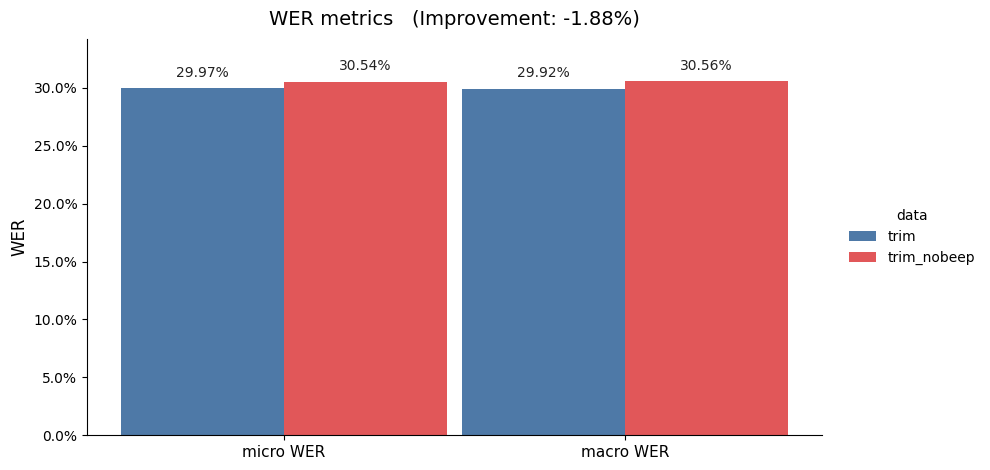

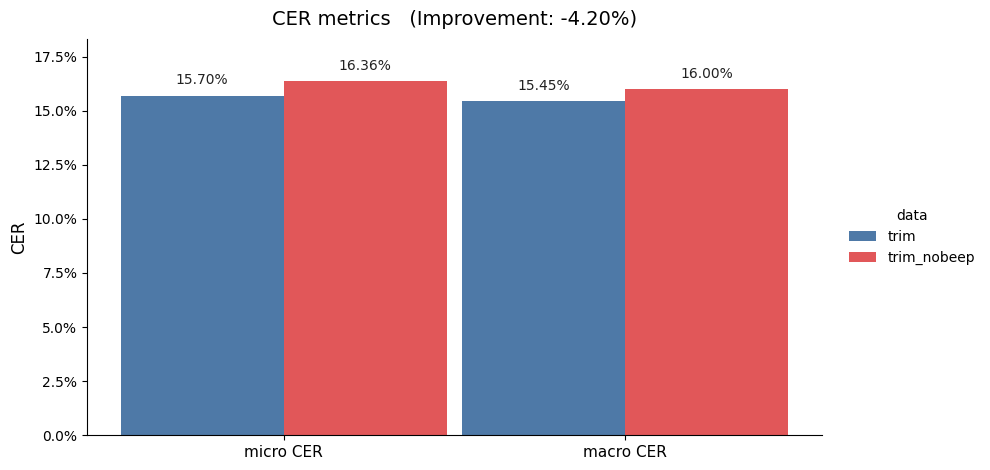

In [7]:
# === from `result` -> metrics 추출 ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

metrics = pd.Series(result["metrics"], name="value").to_frame()
metrics.index.name = "metric"
metrics.reset_index(inplace=True)

def get_val(name, default=None):
    s = metrics.loc[metrics["metric"]==name, "value"]
    return float(s.values[0]) if len(s) else (None if default is None else float(default))

# WER
wer_micro_trim  = get_val("micro_WER_trim")
wer_macro_trim  = get_val("macro_WER_trim")
wer_micro_nb    = get_val("micro_WER_trim_nobeep")
wer_macro_nb    = get_val("macro_WER_trim_nobeep")
wer_impr        = get_val("WER_improvement_%", 0.0)

# CER
cer_micro_trim  = get_val("micro_CER_trim")
cer_macro_trim  = get_val("macro_CER_trim")
cer_micro_nb    = get_val("micro_CER_trim_nobeep")
cer_macro_nb    = get_val("macro_CER_trim_nobeep")
cer_impr        = get_val("CER_improvement_%", 0.0)

# === 깔끔한 그룹 막대 함수 ===
def plot_group_bars(
    title, row_labels, trim_vals, nobeep_vals,
    ylabel="Error Rate", improvement=None,
    figsize=(10, 4.8),
    bar_width=0.24,
    group_gap=0.46,                      # 그룹 간 간격
    colors=("#4E79A7", "#E15759"),       # 보기 좋은 팔레트
    show_grid=False,
    legend_outside=True
):
    x = np.arange(len(row_labels), dtype=float) * group_gap
    ymax = min(max(trim_vals + nobeep_vals) * 1.12, 0.999)

    fig, ax = plt.subplots(figsize=figsize)
    r1 = ax.bar(x - bar_width/2, trim_vals,  width=bar_width,
                color=colors[0], label="trim", linewidth=0)
    r2 = ax.bar(x + bar_width/2, nobeep_vals, width=bar_width,
                color=colors[1], label="trim_nobeep", linewidth=0)

    # 값 라벨(%)
    def annotate(bars):
        for b in bars:
            v = b.get_height()
            ax.annotate(f"{v:.2%}", (b.get_x()+b.get_width()/2., v),
                        textcoords="offset points", xytext=(0, 6),
                        ha="center", va="bottom", fontsize=10, color="#222")
    annotate(r1); annotate(r2)

    ax.set_xticks(x)
    ax.set_xticklabels(row_labels, fontsize=11)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_ylim(0, ymax)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))

    if show_grid:
        ax.grid(axis="y", linestyle="--", alpha=0.15)
    else:
        ax.grid(False)

    for s in ("top", "right"):
        ax.spines[s].set_visible(False)

    ttl = title + (f"   (Improvement: {improvement:+.2f}%)" if improvement is not None else "")
    ax.set_title(ttl, fontsize=14, pad=10)

    if legend_outside:
        ax.legend(title="data", loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
        fig.subplots_adjust(right=0.82)
    else:
        ax.legend(title="data", loc="upper right", frameon=False)

    plt.tight_layout()
    plt.show()

# === 그리기: WER / CER ===
plot_group_bars(
    title="WER metrics",
    row_labels=["micro WER", "macro WER"],
    trim_vals=[wer_micro_trim, wer_macro_trim],
    nobeep_vals=[wer_micro_nb, wer_macro_nb],
    ylabel="WER",
    improvement=wer_impr,
    bar_width=0.22,
    group_gap=0.46,
    show_grid=False
)

plot_group_bars(
    title="CER metrics",
    row_labels=["micro CER", "macro CER"],
    trim_vals=[cer_micro_trim, cer_macro_trim],
    nobeep_vals=[cer_micro_nb, cer_macro_nb],
    ylabel="CER",
    improvement=cer_impr,
    bar_width=0.22,
    group_gap=0.46,
    show_grid=False
)

Confusion Matrix 시각화

In [8]:
confusion_trim_nobeep = confusion_from_alignment(result["alignment"], tag="trim_nobeep", top_n=20)
print(confusion_trim_nobeep)

{'top_sub': [(('정보가', '개인정보가'), 32), (('드릴', '해드릴'), 18), (('저희가', '제가'), 16), (('범죄', '금융범죄'), 15), (('번', '한번'), 15), (('정보', '개인정보'), 14), (('근데', '그런데'), 12), (('분들이', '피해자분들이'), 12), (('고발', '고소고발'), 11), (('본', '해본'), 11), (('그러면은', '그러면'), 10), (('주셔야', '해주셔야'), 10), (('그런데', '근데'), 10), (('주시고', '해주시고'), 10), (('통장으로', '대포통장으로'), 9), (('본인이', '본인'), 9), (('연루가', '연료가'), 9), (('본인', '본인이'), 8), (('그다음에', '다음에'), 8), (('주시면', '해주시면'), 8)], 'top_ins': [('두', 18), ('뭐', 14), ('이', 13), ('지금', 13), ('저', 12), ('네네', 12), ('2', 11), ('안', 10), ('첨단', 9), ('한', 9), ('제가', 8), ('좀', 7), ('이해', 6), ('아니', 6), ('1', 6), ('ㅅㅂ', 6), ('수', 5), ('전화', 5), ('조사', 5), ('감사합니다', 5)], 'top_del': [('이제', 259), ('이', 147), ('뭐', 133), ('해', 117), ('좀', 83), ('지금', 82), ('ooo씨', 80), ('개인', 65), ('금융', 48), ('본인', 47), ('한', 42), ('제가', 38), ('그럼', 37), ('녹취', 36), ('피해자', 35), ('저희', 34), ('명의', 33), ('증거', 30), ('저희가', 30), ('동결', 29)]}


In [9]:
confusion_trim = confusion_from_alignment(result["alignment"], tag="trim", top_n=20)
print(confusion_trim)

{'top_sub': [(('정보가', '개인정보가'), 30), (('드릴', '해드릴'), 18), (('저희가', '제가'), 16), (('범죄', '금융범죄'), 14), (('번', '한번'), 14), (('정보', '개인정보'), 13), (('근데', '그런데'), 12), (('분들이', '피해자분들이'), 12), (('고발', '고소고발'), 11), (('본', '해본'), 11), (('그러면은', '그러면'), 10), (('본인이', '본인'), 10), (('주셔야', '해주셔야'), 10), (('주시고', '해주시고'), 10), (('연루가', '연료가'), 10), (('통장으로', '대포통장으로'), 9), (('그다음에', '다음에'), 8), (('주시면', '해주시면'), 8), (('김형석', '김영석'), 8), (('본인', '본인이'), 7)], 'top_ins': [('두', 18), ('뭐', 16), ('이', 15), ('지금', 14), ('네네', 12), ('2', 12), ('안', 10), ('제가', 9), ('첨단', 9), ('이제', 8), ('저', 8), ('q', 7), ('한', 6), ('1', 6), ('좀', 6), ('ㅅㅂ', 6), ('수', 5), ('이해', 5), ('전화', 5), ('몇', 5)], 'top_del': [('이제', 262), ('이', 138), ('뭐', 132), ('해', 116), ('좀', 79), ('지금', 77), ('개인', 69), ('ooo씨', 61), ('금융', 47), ('본인', 45), ('한', 37), ('녹취', 35), ('명의', 34), ('저희', 34), ('그럼', 34), ('피해자', 34), ('제가', 31), ('동결', 30), ('증거', 27), ('대포', 27)]}


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


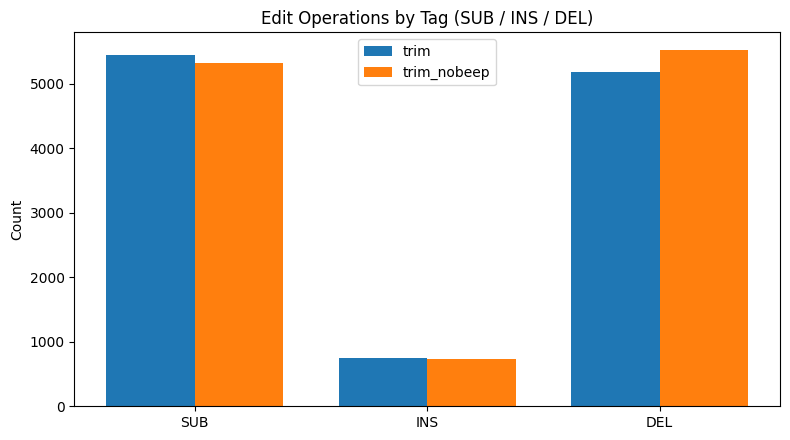

In [22]:
alignment_data = result["alignment"]   # {"<id>::trim": [...], "<id>::trim_nobeep":[...], ...}

# --- tag별 INS/SUB/DEL 집계 ---
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

def tally_ops_by_tag(alignment_data, tags=("trim","trim_nobeep")):
    counts = {tag: Counter({"SUB":0, "INS":0, "DEL":0}) for tag in tags}
    for key, align in alignment_data.items():
        for tag in tags:
            if not key.endswith(f"::{tag}"):
                continue
            for r, h, op in align:   # op ∈ {"MATCH","SUB","INS","DEL"}
                if op in ("SUB","INS","DEL"):
                    counts[tag][op] += 1
    return counts

tags = ("trim","trim_nobeep")
counts = tally_ops_by_tag(alignment_data, tags=tags)

# --- 시각화 (그룹 막대그래프) ---
ops_order = ["SUB","INS","DEL"]
x = np.arange(len(ops_order))
width = 0.38

y_tag0 = [counts[tags[0]][op] for op in ops_order]
y_tag1 = [counts[tags[1]][op] for op in ops_order]

plt.figure(figsize=(8,4.5))
plt.bar(x - width/2, y_tag0, width, label=tags[0])
plt.bar(x + width/2, y_tag1, width, label=tags[1])

plt.xticks(x, ops_order)
plt.ylabel("Count")
plt.title("Edit Operations by Tag (SUB / INS / DEL)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#df_scored_fixed.to_csv('df_scored_fixed.csv', encoding = 'utf-8-sig', index=False)